In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


# Tweets NLP RNN Disaster Detection 

* ****Import Library****

In [3]:
import pathlib
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
# from plotly.subplots import make_subplots
# import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw


# model development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.ops.array_ops import tensor_scatter_update
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Activation, Add, GlobalAveragePooling2D 
from tensorflow.keras import regularizers

* ****Load Data****

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [6]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [7]:
# get training data
train_data = import_data('/kaggle/input/nlp-getting-started/train.csv')
test_data = import_data('/kaggle/input/nlp-getting-started/test.csv')
labels = import_data('/kaggle/input/nlp-getting-started/sample_submission.csv')
print(len(labels))
print(labels.head())
print(train_data.head())
 

Memory usage of dataframe is 0.29 MB
Memory usage after optimization is: 0.54 MB
Decreased by -84.4%
Memory usage of dataframe is 0.10 MB
Memory usage after optimization is: 0.26 MB
Decreased by -161.4%
Memory usage of dataframe is 0.05 MB
Memory usage after optimization is: 0.01 MB
Decreased by 81.1%
3263
   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


**EDA Process**

For NLP, remove all stop words, html, puncutations, shortforms and low case all words.

In [8]:
#remove punctuations
import re
import string
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords
table = str.maketrans("", "", string.punctuation)
def remove_punc(text):
    return text.translate(table)

# Clean text by removing URLs, punctuation, and converting to lowercase
def clean_text(text):
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = text.lower() # Convert to lowercase
    return text

#removing any shortforms if present
def remove_shortforms(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_special_char(text):
    text = re.sub('[^A-Za-z0-9]+'," ",text)
    return text

def remove_wordswithnum(text):
    text = re.sub("\S*\d\S*", "", text).strip()
    return text

def lowercase(text):
    text = text.lower()
    return text

def remove_stop_words(text):
    text = remove_stopwords(text)
    return text

st = SnowballStemmer(language='english')
def stemming(text):
    r= []
    for word in text :
        a = st.stem(word)
        r.append(a)
    return r

def listToString(s):  
    str1 = " "   
    return (str1.join(s))

def remove_punctuations(text):
    text = re.sub(r'[^\w\s]','',text)
    return text

def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    return text

# lemmatizer = WordNetLemmatizer()
# def lemmatize_words(text):
#     text = lemmatizer.lemmatize(text)
#     return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        7613 non-null   int16   
 1   keyword   7552 non-null   category
 2   location  5080 non-null   category
 3   text      7613 non-null   category
 4   target    7613 non-null   int8    
dtypes: category(3), int16(1), int8(1)
memory usage: 548.7 KB


In [10]:
train_data['text'] = train_data.text.apply(lambda x: remove_punc(x))
train_data['text'] = train_data.text.apply(lambda x: clean_text(x))
train_data['text'] = train_data.text.apply(lambda x: remove_shortforms(x))
train_data['text'] = train_data.text.apply(lambda x: remove_wordswithnum(x))
train_data['text'] = train_data.text.apply(lambda x: lowercase(x))
train_data['text'] = train_data.text.apply(lambda x: remove_stop_words(x))
train_data['text'] = train_data.text.apply(lambda x: remove_punctuations(x))
train_data['text'] = train_data.text.apply(lambda x: remove_links(x))
# train_data['text'] = train_data.text.apply(lambda x: lemmatize_words(x))
train_data['text'] = train_data.text.apply(lambda x: remove_html(x))

 
train_data.head(100)



,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake allah forgive,1
1,4,NaN,NaN,forest near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...,...,...,...
95,137,accident,Charlotte,mile backup southaccident blocking right lanes...,1
96,138,accident,"Baton Rouge, LA",accident changed life help determine options f...,0
97,139,accident,"Hagerstown, MD",breaking deadly motorcycle car accident happen...,1
98,141,accident,"Gloucestershire , UK",flowri marinading accident,0


In [11]:
 
test_data['text'] = test_data.text.apply(lambda x: remove_punc(x))
test_data['text'] = test_data.text.apply(lambda x: clean_text(x))
test_data['text'] = test_data.text.apply(lambda x: remove_shortforms(x))
test_data['text'] = test_data.text.apply(lambda x: remove_wordswithnum(x))
test_data['text'] = test_data.text.apply(lambda x: lowercase(x))
test_data['text'] = test_data.text.apply(lambda x: remove_stop_words(x))
test_data['text'] = test_data.text.apply(lambda x: remove_punctuations(x))
test_data['text'] = test_data.text.apply(lambda x: remove_links(x))
# test_data['text'] = test_data.text.apply(lambda x: lemmatize_words(x))
test_data['text'] = test_data.text.apply(lambda x: remove_html(x))
test_data.head(100)

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe
2,3,NaN,NaN,forest spot pond geese fleeing street save
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan
...,...,...,...,...
95,323,annihilated,NaN,nature appropriates love burn annihilated beloved
96,324,annihilated,NaN,ninahoag shred psych work friendship annihilated
97,325,annihilated,upstate NY,thehill example y conservatives annihilated bu...
98,326,annihilated,NaN,aug wiped francis josephs crack regiment annih...


In [12]:
#Remove stopwords

from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

def rem_stop(text):
    word_list = [word for word in text.split() if word not in stop]
    return " ".join(word_list)


**Split the data into Train and Validation dataset.**

In [13]:
import re
train_data['text'] = train_data.text.apply(lambda x: rem_stop(x))
test_data['text'] = test_data.text.apply(lambda x: rem_stop(x))
train_data['text'] = train_data.text.apply(lambda x: clean_text(x))
test_data['text'] = test_data.text.apply(lambda x: clean_text(x))

train_data.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
train_data.head(10)
train_data['target'].value_counts()

 

test_data.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
test_data.head(10)
 

,text
0,happened terrible car crash
1,heard earthquake different cities stay safe
2,forest spot pond geese fleeing street save
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills china taiwan
5,shakingits earthquake
6,theyd probably life arsenal yesterday eh eh
7,hey
8,nice hat
9,fuck


In [14]:
train_X = train_data.drop(['target'],axis=1).to_numpy().reshape(-1,)
train_y = train_data['target'].to_numpy()

test_data =test_data.to_numpy().reshape(-1,)

Tokenization and Padding

Building the Model

In [15]:
from sklearn.model_selection import train_test_split
# X_train_dev, X_test, y_train_dev, y_test = train_test_split(bigX, bigy,
#                                                     stratify=bigy,
#                                                     test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y,
                                                    stratify=train_y,
                                                    test_size=0.2)

In [16]:
print(train_X.shape)
print(train_X[0])

(7613,)
deeds reason earthquake allah forgive


In [17]:
maxlen = 0
vocab = {"PAD": 0, "UNK": 1}
for i in range(len(train_X)) :
    if len(train_X[i]) > maxlen:
        maxlen = len(train_X[i])
    for word in train_X[i].split():
        if word not in vocab:               # word has not been assigned an index yet
            vocab[word] = len(vocab)        # Assign each word with a unique index
print(maxlen, len(vocab))

vocab_size = len(vocab)

138 16361


**We will use two model for comparing the accuracy, one is RNN LTSM, the other is RNN GRU**

**RNN LTSM Model**

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_words = 1000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
padded_seq_train =  pad_sequences(sequences,maxlen=max_len)
 
sequences_val = tokenizer.texts_to_sequences(X_val)
padded_seq_val =  pad_sequences(sequences_val,maxlen=max_len)
 
print(padded_seq_train.shape)
print(padded_seq_val.shape)

 

(6090, 150)
(1523, 150)


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_words = 1000
max_len = 150
tokenizer_test = Tokenizer(num_words=max_words)

tokenizer_test.fit_on_texts(test_data)
sequences_test = tokenizer_test.texts_to_sequences(test_data)
padded_seq_test =  pad_sequences(sequences_test,maxlen=max_len)
 
 
 

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = models.Sequential()



model.add(layers.Embedding(max_words,50,input_length=max_len, input_shape=[max_len]))
# model.add(SimpleRNN(units=64))
# model.add(layers.LSTM(64, dropout=0.5))
model.add(layers.LSTM(100,return_sequences=True)) 
model.add(layers.LSTM(200))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# model.summary()

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
 

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary() 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 150, 100)          60400     
                                                                 
 lstm_1 (LSTM)               (None, 200)               240800    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 402,913
Trainable params: 402,913
Non-trai

In [52]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=3)
# history = model.fit(padded_seq_train,
#                     y_train,
#                     epochs=20,
#                     batch_size=72,
#                     validation_data=(padded_seq_val, y_val))
# adding early stopping monitor to determine the best validation accuracy for the mode
history = model.fit(padded_seq_train,y_train,
                    batch_size=72,
                    epochs=30,
                    validation_data=(padded_seq_val, y_val) 
#                     callbacks=[es]
)

Epoch 1/30
85/85 [==============================] - 56s 661ms/step - loss: 0.3877 - accuracy: 0.8378 - val_loss: 0.4816 - val_accuracy: 0.7833
Epoch 2/30
85/85 [==============================] - 54s 641ms/step - loss: 0.3821 - accuracy: 0.8394 - val_loss: 0.4907 - val_accuracy: 0.7787
Epoch 3/30
85/85 [==============================] - 54s 639ms/step - loss: 0.3749 - accuracy: 0.8435 - val_loss: 0.4867 - val_accuracy: 0.7774
Epoch 4/30
85/85 [==============================] - 55s 643ms/step - loss: 0.3714 - accuracy: 0.8443 - val_loss: 0.4867 - val_accuracy: 0.7754
Epoch 5/30
85/85 [==============================] - 54s 632ms/step - loss: 0.4726 - accuracy: 0.8241 - val_loss: 0.4789 - val_accuracy: 0.7761
Epoch 6/30
85/85 [==============================] - 54s 632ms/step - loss: 0.4700 - accuracy: 0.8034 - val_loss: 0.4995 - val_accuracy: 0.7663
Epoch 7/30
85/85 [==============================] - 55s 647ms/step - loss: 0.4187 - accuracy: 0.8192 - val_loss: 0.5085 - val_accuracy: 0.7663

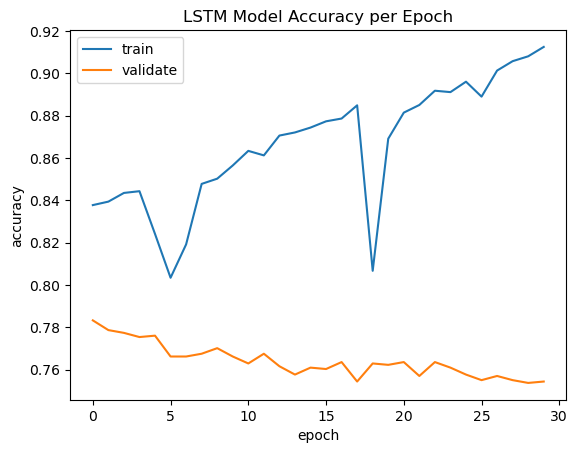

In [53]:
# plot model accuracy per epoch 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

**GRU Based RNN Model**

for training a GRU-based RNN for text classification using PyTorch

In [23]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
print(y_val_cat.shape)
print(y_val.shape)
print(y_val_cat )
print(y_val )

(1523, 2)
(1523,)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
[0 1 1 ... 0 1 1]


In [24]:
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, Bidirectional, SpatialDropout1D
EMBEDDING_DIM = 256
print(vocab_size,maxlen) 
model_gru = Sequential()
model_gru.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=150))
model_gru.add(SpatialDropout1D(0.2))
model_gru.add(Bidirectional(GRU(128)))
model_gru.add(Dense(128, activation='sigmoid'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(2, activation='softmax'))
model_gru.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
# model_gru.compile(loss='binary_crossentropy', optimizer='adam')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
model_gru.summary()

16361 138
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 256)          4188416   
                                                                 
 spatial_dropout1d (SpatialD  (None, 150, 256)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              296448    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)      

In [25]:
# X_train, X_val, y_train, y_val
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=3)
# history1 = model_gru.fit(padded_seq_train, y_train_cat, epochs=20, validation_data=(padded_seq_val, y_val_cat), batch_size=64, callbacks=[callback])
history1 = model_gru.fit(padded_seq_train, y_train_cat, epochs=20, validation_data=(padded_seq_val, y_val_cat), batch_size=64, callbacks=[es])
# history1 = model_gru.fit(padded_seq_train, y_train, epochs=20, validation_data=(padded_seq_val, y_val), batch_size=64, callbacks=[es])

Epoch 1/20
96/96 [==============================] - 48s 459ms/step - loss: 0.6727 - accuracy: 0.5844 - val_loss: 0.5680 - val_accuracy: 0.7203
Epoch 2/20
96/96 [==============================] - 44s 454ms/step - loss: 0.4895 - accuracy: 0.7698 - val_loss: 0.4770 - val_accuracy: 0.7676
Epoch 3/20
96/96 [==============================] - 43s 444ms/step - loss: 0.4307 - accuracy: 0.8067 - val_loss: 0.4725 - val_accuracy: 0.7761
Epoch 4/20
96/96 [==============================] - 42s 441ms/step - loss: 0.4067 - accuracy: 0.8182 - val_loss: 0.4771 - val_accuracy: 0.7840
Epoch 5/20
96/96 [==============================] - 43s 450ms/step - loss: 0.3957 - accuracy: 0.8233 - val_loss: 0.4735 - val_accuracy: 0.7807
Epoch 6/20
96/96 [==============================] - 43s 449ms/step - loss: 0.3881 - accuracy: 0.8307 - val_loss: 0.4823 - val_accuracy: 0.7761
Epoch 7/20
96/96 [==============================] - 43s 449ms/step - loss: 0.3783 - accuracy: 0.8319 - val_loss: 0.4948 - val_accuracy: 0.7741

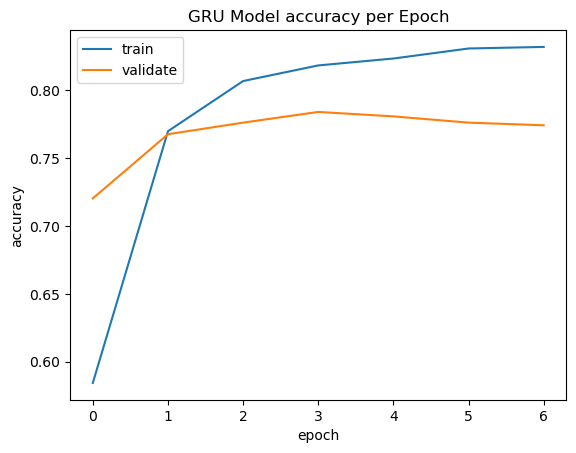

In [26]:
# plot model accuracy per epoch 
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('GRU Model accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

**Conclusin**

I made two model, one is LTSM RNN, the other is GRU RNN, compared the val_accuracy, GRU RNN is better than LTSM RNN, so I will use the GRU RNN model to export and submit the test dataset results for grading.

**Export the best result into file**


In [27]:
# Making Prediction
y_pred = model_gru.predict(padded_seq_test)
# y_pred = model.predict(padded_seq_test)

102/102 [==============================] - 7s 65ms/step


In [54]:
predictions = model.predict(padded_seq_test, verbose=1)

102/102 [==============================] - 14s 138ms/step


In [ ]:
test_data = import_data('/kaggle/input/nlp-getting-started/test.csv')
print(test_data['id'])

In [60]:
id_col = test_data['id']
test = test_data.drop(['id', 'keyword', 'location'], axis=1).to_numpy().reshape(-1,)
sequences = tokenizer.texts_to_sequences(test)
sequences_matrix_test_final =  pad_sequences(sequences,maxlen=max_len)
y_pred = model.predict(sequences_matrix_test_final)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
y_pred = y_pred.astype(int)
y_pred

102/102 [==============================] - 14s 137ms/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [61]:
prediction_df = pd.DataFrame()
prediction_df['id'] = id_col
prediction_df['target'] = y_pred
prediction_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [62]:
prediction_df.to_csv('submission.csv', index=False)

In [55]:
predictions1 = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'] 
submission_df['target'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions1))
submission_df.head()
 

,id,target
0,0,1
1,2,1
2,3,0
3,9,1
4,11,0


In [57]:
submission_df.to_csv('submission.csv', index=False)